# Exp 5 : Google stock prices

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader.data as web
import datetime
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Importing the Keras libraries and packages
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense
from keras.layers import LSTM        # Long Short-Term Memory layer
from keras.layers import Dropout     # simple way to prevent overfitting

In [2]:
# Configuration

SHARE = 'AAPL'
SERVICE = 'fred' #'quandl' #'yahoo'

PREDICTORS = ['Open']  #['High', 'Low', 'Open']   # column names with prices
TARGET = 'Open'

TIMESTEP = 90  # the number of previous days used for prediction

START_DATE = datetime.datetime(2010, 1, 1)  # doesn't work for Kaggle Notebook, train set is used instead 
END_DATE = datetime.datetime(2019, 9, 30)

START_DATE_TO_PREDICT = datetime.datetime(2019, 10, 1)  # doesn't work for Kaggle,test set is used instead
END_DATE_TO_PREDICT = datetime.datetime(2019, 10, 31)

N_EPOCHS = 100

In [3]:
# Download stock price data

# For some reason web.DataReader doesn't work on Kaggle

#df_train = web.DataReader(SHARE, SERVICE, START_DATE, END_DATE)
#df_test = web.DataReader(SHARE, SERVICE, START_DATE_TO_PREDICT, END_DATE_TO_PREDICT)

df_train = pd.read_csv('Google_Stock_Price_Train.csv')
df_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [4]:
df_test.tail()

,Date,Open,High,Low,Close,Volume
15,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500"
16,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900"
17,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800"
18,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600"
19,1/31/2017,796.86,801.25,790.52,796.79,"2,160,600"


In [5]:
# Data preprocessing

# Fix for used input files on Kaggle
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

# Removing irrelevant columns
df_train = df_train[PREDICTORS]
df_test = df_test[PREDICTORS]

In [6]:
# Creating numpy 2-dim array for the training set
# size N x K, where N - number of observations
# K - number of predictors

training_set = df_train.values

In [7]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Creating a data structure with timesteps and 1 output
# X_train - 3-dim array size of N x M x K, where 
# N - number of observations
# M - number of previous days (TIMESTEP)
# K - number of predictors/indicators
 
X_train = []
y_train = []
target_col_index = df_train.columns.get_loc(TARGET)
for i in range(TIMESTEP, len(training_set)):
    X_train.append(training_set_scaled[i-TIMESTEP:i, :])       # X_train - list of Numpy arrays
    y_train.append(training_set_scaled[i, target_col_index])
X_train, y_train = np.array(X_train), np.array(y_train)        # convert list to Numpy array

In [9]:
# Building the RNN


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer - dense layer 
# classic fully connected neural network layer : each input node is connected to each output node
regressor.add(Dense(units = 1))

# Compiling the RNN
# use MSE instead RMSE (Root Mean Squared Error) because we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 9s 97ms/step - loss: 0.0441
Epoch 2/100
37/37 [==============================] - 4s 103ms/step - loss: 0.0074
Epoch 3/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0059
Epoch 4/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0056
Epoch 5/100
37/37 [==============================] - 4s 104ms/step - loss: 0.0066
Epoch 6/100
37/37 [==============================] - 4s 114ms/step - loss: 0.0049
Epoch 7/100
37/37 [==============================] - 4s 104ms/step - loss: 0.0047
Epoch 8/100
37/37 [==============================] - 4s 104ms/step - loss: 0.0044
Epoch 9/100
37/37 [==============================] - 4s 108ms/step - loss: 0.0041
Epoch 10/100
37/37 [==============================] - 4s 110ms/step - loss: 0.0040
Epoch 11/100
37/37 [==============================] - 4s 109ms/step - loss: 0.0044
Epoch 12/100
37/37 [==============================] - 6s 158ms/step - loss: 0.0043
Epoch 13/100
3

37/37 [==============================] - 3s 93ms/step - loss: 0.0016


In [10]:
# Extracting real prices
real_stock_price = df_test[TARGET].values

# Preparing input data for making predictions
df_total = df_train.append(df_test)
inputs = df_total[len(df_total) - len(df_test) - TIMESTEP:][PREDICTORS]

inputs = sc.transform(inputs)


X_test = []
for i in range(TIMESTEP, TIMESTEP+len(df_test)):
    X_test.append(inputs[i-TIMESTEP:i, :])
X_test = np.array(X_test)

In [11]:
# Making the predictions

predicted_stock_price = regressor.predict(X_test)

# to perform inverse scaler transformation, at first we need to transform 
# 1-dimensional array with predicted prices to 2-dim array of size N x K, 
# where N = number of observations/predictions. 
# K = number of predictors

temp_matrix = np.zeros((len(predicted_stock_price), len(PREDICTORS)))
temp_matrix[:,target_col_index:target_col_index+1] = predicted_stock_price  # temp_matrix[:,[target_col_index]] = predicted_stock_price    

predicted_stock_price = sc.inverse_transform(temp_matrix)[:,target_col_index]

1/1 [==============================] - 2s 2s/step


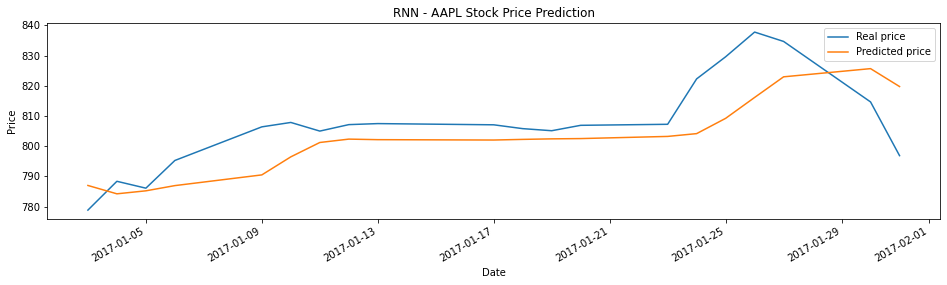

In [12]:
#df_predicted = pd.DataFrame(index=df_test.index)
#df_predicted[TARGET] = predicted_stock_price

df_test['Predicted price'] = predicted_stock_price
df_test[TARGET].plot(figsize=(16,4),legend=True)
df_test['Predicted price'].plot(figsize=(16,4),legend=True)
plt.legend(['Real price', 'Predicted price'])
plt.title('RNN - ' + SHARE + ' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
# Evaluating model
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("The RMSE is {:.3f}.".format(rmse))

The RMSE is 11.582.
